(sec:feature-extraction)=
# 画像特徴量の抽出

In [ ]:
"""
下準備のコード
"""

import os
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.exceptions import ConvergenceWarning

try:
    from myst_nb import glue
except ImportError:
    glue = lambda *args, **kwargs: _

# 実験に用いるデータ数
n_images_per_char = 200
glue("n_images_per_char", n_images_per_char)

# 一部の警告を無視
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", ConvergenceWarning)

# シードの固定
random.seed(31415)
np.random.seed(31415)

# グラフの設定
rc = {"figure.dpi": 150}
sns.set_theme(style="white", palette="colorblind", rc=rc)

# 結果を格納しておくDataFrame
result_df = pd.DataFrame(
    {
        "Method": pd.Series([], dtype="string"),
        "Accuracy": pd.Series([], dtype="float64"),
        "Phase": pd.Series([], dtype="string"),
    }
)

200

今回からは数字ではなく「ひらがな」のデータセットを用いて、より複雑な識別問題に取り組む。

データセットは国立国会図書館の[NDLラボ](https://lab.ndl.go.jp/)が公開している文字画像データセットを使用する。

- 文字画像データセット: <https://github.com/ndl-lab/hiragana_mojigazo>

実際のデータセットは、以下のURLにホストされているので、ここからダウンロードする。

**文字画像データセット(平仮名73文字版) (zip形式)** 

- <http://lab.ndl.go.jp/dataset/hiragana73.zip>

In [ ]:
"""
平仮名73文字データセットの準備
"""

import zipfile

import requests

url = "http://lab.ndl.go.jp/dataset/hiragana73.zip"
filename = os.path.basename(url)

# HTTPリクエストを送ってデータサイズを取得
r = requests.get(url, stream=True)
total_size = int(r.headers.get("content-length", 0))
chunk_size = 65535

# "hiragana73"フォルダが存在し、その中身が空でないことを確認
if not os.path.exists("./hiragana73") or len(os.listdir("./hiragana73")) == 0:
    # 実際のファイルのダウンロード
    pbar = tqdm(total=total_size, unit="B", unit_scale=True)
    with open(filename, "wb") as f:
        for data in r.iter_content(chunk_size):
            f.write(data)
            pbar.update(chunk_size)

    # ダウンロードが完了したらZIPを展開する
    with zipfile.ZipFile(filename, "r") as f:
        f.extractall()

## データセットの前処理

このデータセットは濁音、半濁音を含むひらがな73文字に対して、そのUnicode値のフォルダの中に、48×48の画像がPNG形式で保存されている。

各ひらがなのUnicode値を調べるには、`ord`関数を用いてUnicode値に変換した後に、それを`hex`関数を用いて16進数表記の文字列に変換すれば良い。

一例として「あ」であれば、以下のようにUnicode値を得ることができる。

In [ ]:
char_a = "あ"
hex_a = hex(ord(char_a))
print(f"Unicode of '{char_a:s}' is '{hex_a:s}'")

Unicode of 'あ' is '0x3042'


逆に、あいうえお順で文字を取得したければ、「あ」に対応するUnicode値である`0x3042`からスタートして、1ずつ値を上げていきながら、その数字を`chr`関数を用いて文字に変換すれば良い。

なお、16進数の文字列を整数に直したいときには、`int(hex_a)`と単に文字列を渡すだけではダメで、第2引数に何進数の数字なのかを与えて `int(hex_a, 16)` のようにする必要があることに注意すること。

上記のひらがなデータセットは「ゃ」や「っ」などの小文字を含まない73文字から構成されているが、「あ」から「ん」までは、小文字を含め82文字なので、これを列挙してみる。

In [ ]:
for i in range(82):
    print(chr(int(hex_a, 16) + i), end="")
    if (i + 1) % 10 == 0:
        print()

あぃいぅうぇえぉおか
がきぎくぐけげこごさ
ざしじすずせぜそぞた
だちぢっつづてでとど
なにぬねのはばぱひび
ぴふぶぷへべぺほぼぽ
まみむめもゃやゅゆょ
よらりるれろゎわゐゑ
をん

ひらがなデータセットのフォルダ名は16進数を表わす`0x`の代わりに`U`が接頭辞になっているので、フォルダ名の`U`を`0x`に置換して、どの文字がデータセットに含まれているかをチェックしてみる。

In [ ]:
# サブフォルダの数を調べる
dirname = "hiragana73"
folders = sorted([d for d in os.listdir(dirname)])
print('There are {:d} folders in "{:s}".'.format(len(folders), dirname))

# フォルダに対応する文字を列挙
for i, d in enumerate(folders):
    x = d.replace("U", "0x")
    print(chr(int(x, 16)), end="")
    if (i + 1) % 10 == 0:
        print()

There are 73 folders in "hiragana73".
あいうえおかがきぎく
ぐけげこごさざしじす
ずせぜそぞただちぢつ
づてでとどなにぬねの
はばぱひびぴふぶぷへ
べぺほぼぽまみむめも
やゆよらりるれろわゐ
ゑをん

なお、本データセットでは各文字に対して以下の表に書かれた個数ずつ画像が含まれており、文字によって画像数に多少の偏りがあることが分かる。

In [ ]:
import numpy as np
import pandas as pd

chars = [chr(int(d.replace("U", "0x"), 16)) for d in folders]
dir_paths = [os.path.join(dirname, d) for d in folders]
num_images = [len(os.listdir(d)) for d in dir_paths]

df = pd.DataFrame([(c, n) for c, n in zip(chars, num_images)])
sub_dfs = [df[i : i + 10].reset_index(drop=True) for i in range(0, len(df.index), 10)]
df = pd.concat(sub_dfs, axis=1).fillna("")

df.index = [i for i in range(len(df.index))]
df.columns = [j for j in range(len(df.columns))]


def custom_style(df):
    index = df.index
    columns = df.columns
    styles = []
    for i in range(len(index)):
        s = []
        for j in range(len(columns)):
            if columns[j] % 2 == 0:
                s.append("font-weight: bold;")
            else:
                s.append(None)
        styles.append(s)

    return np.array(styles, dtype="object")


df.style.format(precision=0).format_index("", axis=1).format_index("", axis=0).apply(
    custom_style, axis=None
)

,,,,,,,,,,,,,,,,
,あ,1208,ぐ,1043,ず,1046,づ,1080,は,1247,べ,1109,や,1285,ゑ,1030
,い,1122,け,1155,せ,1165,て,1213,ば,1105,ぺ,268,ゆ,1282,を,1254
,う,1148,げ,1058,ぜ,1115,で,1178,ぱ,262,ほ,1115,よ,1166,ん,1285
,え,1077,こ,1115,そ,1285,と,1184,ひ,1074,ぼ,1044,ら,1114,,
,お,1283,ご,1078,ぞ,1066,ど,1134,び,1045,ぽ,261,り,1244,,
,か,1259,さ,1261,た,1285,な,1233,ぴ,126,ま,1285,る,1190,,
,が,1200,ざ,1070,だ,1116,に,1260,ふ,1285,み,1142,れ,1238,,
,き,1121,し,1285,ち,1052,ぬ,1093,ぶ,1149,む,1058,ろ,1069,,
,ぎ,1091,じ,1099,ぢ,1132,ね,1126,ぷ,112,め,1233,わ,1283,,
,く,1266,す,1282,つ,1142,の,1160,へ,1114,も,1187,ゐ,1053,,


この表が示すとおり、各文字について、約1000の画像が含まれていることが確認できる。ただし、半濁音のひらがなは全体的に少なめで100-200程度となっている。

### 分類用のデータ加工

MNISTでは手書き文字の画像が28x28=576次元ベクトル、ラベルが10種類の数字のいずれかを表わす0-9の数字であり、これらのデータを`scikit-learn`の`fetch_openml`から取得することができた。

このようなデータをひらがなデータセットに対して自前で作成しよう。今回のデータセットは、
- 濁音や半濁音、小文字を含まないひらがな46文字を扱う
- 各文字の画像をランダムに{glue:text}`n_images_per_char`枚取り出す
- 分類の難易度を上げるため、画像をランダムに回転したり、拡大縮小したりする
という条件の下で作成する。

In [ ]:
# 今回取り扱う平仮名のリスト
chars = "あいうえおかきくけこさしすせそたちつてとなにぬねのはひふへほまみむめもやゆよらりるれろわゐゑをん"
n_chars = len(chars)
char2num = {c: i for i, c in enumerate(chars)}
print(f"We have {n_chars} hiragana characters.")

We have 46 hiragana characters.


In [ ]:
import cv2

# 読み込み画像の総数
n_total = n_images_per_char * n_chars

# 画像の読み取り
X = []  # 画像データ
y = []  # ラベルデータ
pbar = tqdm(total=n_total)
for c in chars:
    # 文字に対する数字を計算
    num = char2num[c]
    char_dir = os.path.join(dirname, "U{:04X}".format(ord(c)))

    # 画像の読み込み
    image_files = [os.path.join(char_dir, f) for f in os.listdir(char_dir)]
    image_files = [f for f in image_files if f.endswith(".png")]

    image_files = np.random.choice(image_files, n_images_per_char, replace=False)
    for f in image_files:
        # グレースケールで画像を読み込む
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise IOError("Failed to load image: {:s}".format(f))

        # ランダム輝度変更
        factor = np.random.uniform(0.9, 1.1)
        image = (((image / 255.0) ** factor) * 255.0).astype("uint8")

        # データのランダム回転、ランダムスケール
        height, width = image.shape
        center = (width // 2, height // 2)
        scale = np.random.uniform(0.8, 1.1)
        angle = np.random.uniform(-60, 60)
        trans = cv2.getRotationMatrix2D(center, angle, scale)
        image = cv2.warpAffine(image, trans, (width, height), borderMode=cv2.BORDER_REPLICATE)

        # ランダムノイズを付加
        image = (image / 255.0).astype("float32")
        image = np.clip(image + np.random.normal(0.0, 0.02, size=image.shape), 0.0, 1.0)
        image = (image * 255.0).astype("uint8")

        X.append(image.flatten())
        y.append(num)

        pbar.update(1)

X = np.stack(X, axis=0)
y = np.stack(y, axis=0)
pbar.close()

  0%|          | 0/9200 [00:00<?, ?it/s]

データセットの作成が終了したら、8割の画像を訓練画像、残りの2割の画像をテスト画像として振り分けておく。

In [ ]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

print(f"#train: {len(X)}")
print(f" #test: {len(X_test)}")

#train: 7360
 #test: 1840


データセットの先頭数枚の画像は次のようになっている。

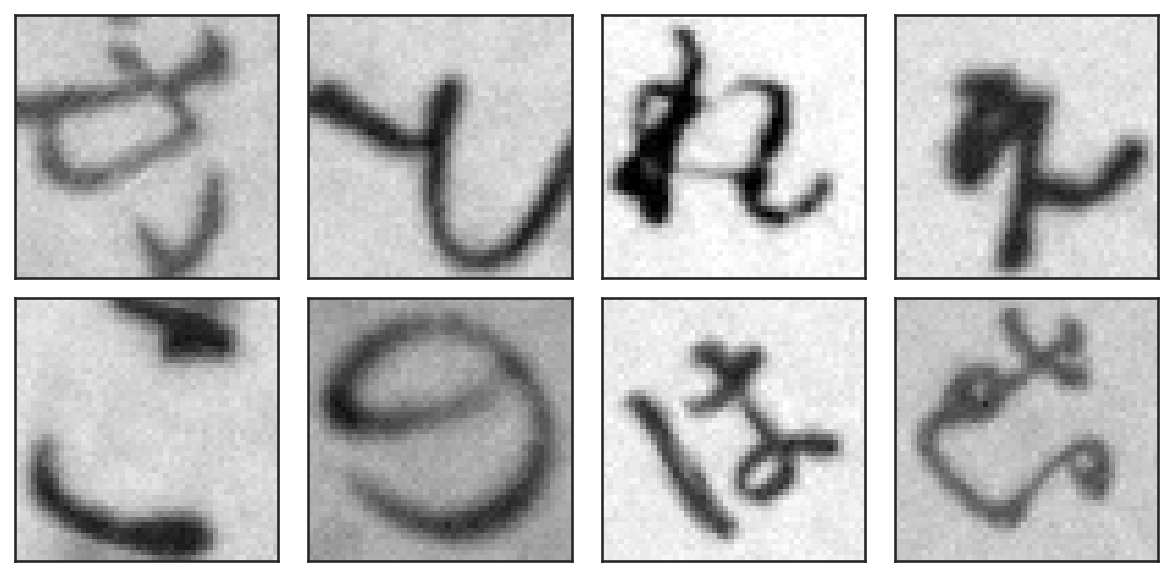

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(2, 4, figure=fig)

for i in range(8):
    ax = plt.subplot(gs[i])
    img = X[i].reshape((48, 48))
    ax.imshow(img, cmap="gray", vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### 線形SVMによる分類

まずは、MNISTの時と同様にscikit-learnによる分類を試してみる。この時、[scikit-learnの節](sec:scikit-learn)で紹介したように、予め入力データの輝度を正規化する処理である`StandardScaler`を使用する。

ただし、従来の`LiearSVC`は学習がやや低速であるので、今回はミニバッチにより効率的に学習が可能な`SGDClassifier`を代わりに用いる。このクラスは、内部でデータセットの一部だけミニバッチとして分類器のパラメータ更新に用いる**確率的最急降下法** (SGD=Stochastic Gradient Descent)により学習を行う。

`SGDClassifier`はパラメータに`loss="hinge"`を渡すと、内部では線形SVMをモデルに使用する。本パラメータは初期値が`"hinge"`であるが、以下に示すソースコードでは、明示的にパラメータを指定する。

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss="hinge"),
)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [ ]:
glue("naive_acc_train", acc_train * 100.0)
glue("naive_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["Image", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["Image", acc_test, "Test"]

76.1820652173913

57.66304347826087

**結果: 画像をそのまま入力**

- 訓練時精度: {glue:text}`naive_acc_train:.2f`%
- 評価時精度: {glue:text}`naive_acc_test:.2f`%

このように、今回は分類問題の難易度が上がっており、SVMを用いても十分な精度が得られていないことが分かる。これには画像を扱う上で次のような問題が考えられる。

- 単に画像をベクトルとして扱うのは、(特に入力画像が大きい場合には)計算効率の観点からも好ましくない
- データセット中の画像上で文字の大きさや向きが揃っていない

これらの問題を解決すべく、以下では、文字の向きや大きさに依存しづらく、画像情報よりも低次かつ有意な特徴を取り出して、その特徴を元に分類器を学習する方法を紹介する。

## 主成分分析による次元圧縮

まずは、学習の効率化を図るために、前項、[次元削減](sec:data-visualization)で紹介した主成分分析を用いて、画像データを低次元ベクトルに変換する。

`make_pipeline`を用いた分類器の定義において、`StandardScaler`の前に`PCA`による次元削減を追加する。

In [ ]:
from sklearn.decomposition import PCA

clf = make_pipeline(
    PCA(n_components=128),
    StandardScaler(),
    SGDClassifier(loss="hinge"),
)
clf.fit(X, y)

Pipeline(steps=[('pca', PCA(n_components=128)),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [ ]:
glue("pca_acc_train", acc_train * 100.0)
glue("pca_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["PCA", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["PCA", acc_test, "Test"]

61.059782608695656

39.67391304347826

**結果: 主成分分析による次元圧縮**

- 訓練時精度: {glue:text}`pca_acc_train:.2f`%
- 評価時精度: {glue:text}`pca_acc_test:.2f`%

PCAによる次元削減を用いると、画像の中から顕著な特徴が抜き出されるものの、若干情報量としては減少してしまうため、単純に適用するだけでは精度が低下する。一方、画像を低次元ベクトルに置き換えたことで、学習に要する時間は大幅に削減される。

## Local Binary Pattern (LBP)

Local Binary Pattern (LBP)は、とある画素を中心とした3x3の領域について、中心画素と周りの画素の輝度の大小関係を数値化する手法である {cite}`ojala1996comparative`。

画素の輝度の大小関係を数値化するということは、画像全体が明るくなったり、暗くなったりしても値がほとんど変化しない、ということであり、LBPは画像輝度の変化に頑健な特徴と言える。

LBPの計算を理解するための一例として、とある中心画素周辺の画素値が以下のようになっている場合を考えよう。

In [ ]:
def draw_frame(problem, fig, ax):
    mask = (problem == 0).astype("float32")
    frame = []
    ax.set_xticks(np.arange(0, 9))
    ax.set_yticks(np.arange(0, 9))
    ax.set_xticklabels(np.arange(1, 10))
    ax.set_yticklabels(np.arange(1, 10))

    ax.set_xticks(np.arange(1, 10) - 0.5, minor=True)
    ax.set_yticks(np.arange(1, 10) - 0.5, minor=True)
    ax.set_xticks(np.arange(3, 10, 3) - 0.5)
    ax.set_yticks(np.arange(3, 10, 3) - 0.5)

    ims = plt.imshow(mask * 0.2, cmap="Blues", vmin=0.0, vmax=1.0)
    frame.append(ims)
    for (i, j), z in np.ndenumerate(problem):
        txt = ax.text(j, i, "{:d}".format(z), ha="center", va="center", color="k", fontsize=15)
        frame.append(txt)

    ax.grid(which="minor", color="k", linestyle="-", linewidth=0.5)
    ax.grid(which="major", color="k", linestyle="-", linewidth=1.0)

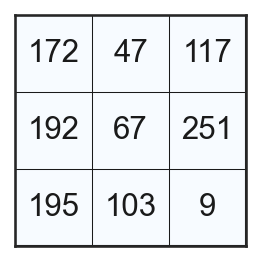

In [ ]:
rng = np.random.RandomState(0)
m = rng.randint(0, 256, size=(3, 3))
fig, ax = plt.subplots(figsize=(2, 2))
draw_frame(m, fig, ax)

このとき、中心画素と周囲の8画素の大小を見比べて、大きいものを1, 小さいものを0に置き換える。

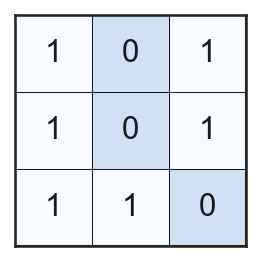

In [ ]:
c = m[1, 1]
b = (m > c).astype("int32")
fig, ax = plt.subplots(figsize=(2, 2))
draw_frame(b, fig, ax)

この周囲の8画素に割り当てられた0, 1のパターンが8ビットの符号なし整数であると考えて数値を求める。この際、以下のような時計回りに2のべき乗が並んだ画像を用いる。

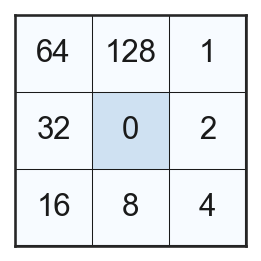

In [ ]:
p = 2 ** np.array([[6, 7, 0], [5, 0, 1], [4, 3, 2]])
p[1, 1] = 0

fig, ax = plt.subplots(figsize=(2, 2))
draw_frame(p, fig, ax)

In [ ]:
glue("lbp_val", np.sum(b * p))

123

すると、上記の3x3の領域に対しては、LBPの値として**{glue}`lbp_val`**が求まる。

この計算を先ほどと同様にデータセットの先頭画像の各画素に対して計算すると、LBP画像は次のようになる。

In [ ]:
img = X[0].reshape((48, 48))

# 輪郭の画素では計算できないので、画像を1画素分広げる
img = np.pad(img, (1, 1), mode="edge")

# 各画素のLBPを計算
lbp_img = np.zeros_like(img).astype("uint8")
for j in range(1, img.shape[0] - 1):
    for i in range(1, img.shape[1] - 1):
        c = img[i, j]
        m = img[i - 1 : i + 2, j - 1 : j + 2]
        b = (m > c).astype("int32")
        lbp_img[i, j] = np.sum(p * b)

lbp_img = lbp_img[1:-1, 1:-1]

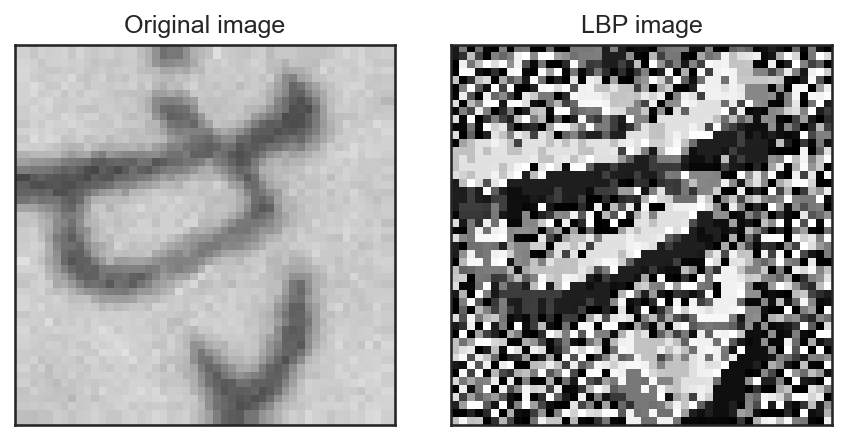

In [ ]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6, 3))
gs = GridSpec(1, 2, figure=fig)

ax = plt.subplot(gs[0])
ax.imshow(img, cmap="gray", vmin=0, vmax=255)
ax.set(xticks=[], yticks=[], title="Original image")

ax = plt.subplot(gs[1])
ax.imshow(lbp_img, cmap="gray", vmin=0, vmax=255)
ax.set(xticks=[], yticks=[], title="LBP image")

plt.tight_layout()
plt.show()

LBPを用いることの利点は画像の**相対的な輝度の大小だけを見ている**点にあり、仮に画像の輝度が2倍になったりしても求まるLBPの値は全く変化しない。そのため、同じ対象を異なる光源下で計算した場合などに一貫した特徴を得られる。

ただし、このままLBP画像を扱うだけでは、得られる特徴ベクトルが画素の並びに強く依存することになるため、LBP画像をヒストグラム化することを考える。この際、画像全体をヒストグラム化するのではなく、画像をいくつかのパッチに分割して、パッチごとに計算したLBP画像の輝度ヒストグラムを一つにつなげて特徴ベクトルとして用いる。

In [ ]:
ps = 8  # パッチサイズ
h, w = lbp_img.shape

lbp_patches = [lbp_img[y : y + ps, x : x + ps] for y in range(0, h, ps) for x in range(0, w, ps)]

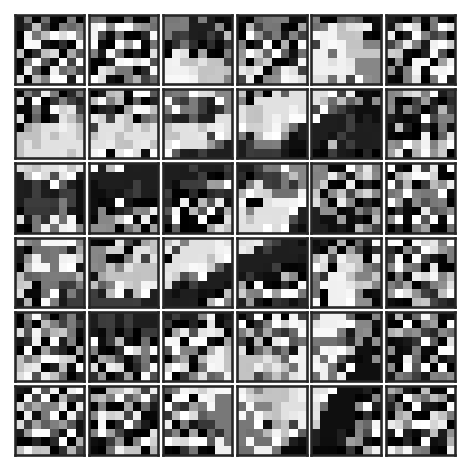

In [ ]:
fig = plt.figure(figsize=(3, 3))
gs = GridSpec(6, 6, figure=fig)
for i in range(36):
    ax = plt.subplot(gs[i])
    ax.imshow(lbp_patches[i], cmap="gray", vmin=0, vmax=255)
    ax.set(xticks=[], yticks=[])

plt.tight_layout(pad=0.2)
plt.show()

In [ ]:
feature = []

# パッチごとにLBPヒストグラムを計算
for patch in lbp_patches:
    hist, _ = np.histogram(patch, bins=32, range=(0, 256))
    feature.append(hist)

# 特徴ベクトルを一つにつなげる
feature = np.concatenate(feature, axis=0)

print(f"Feature shape: {feature.shape}")

Feature shape: (1152,)


これまでの議論をもとに、入力画像をLBP画像に変換するクラスを作成しよう。

scikit-learnを用いて、独自の特徴抽出の仕組みを作るためには`sklearn.base`に用意されているMixinクラスを用いる。今回は画像をLBP画像に「変換する」クラスを作成するので`TransformerMixin`を用いる。

`TransformerMixin`は`StandardScaler`や`PCA`のように`fit`と`transform`を抽象メソッドとして有しているので、新しいサブクラスを作るにはこれらのメソッドをオーバーライドすれば良い。

In [ ]:
from sklearn.base import TransformerMixin


class LBPFeature(TransformerMixin):
    """
    画像からLBP画像を計算するクラス
    """

    def __init__(self, image_size):
        self.image_size = image_size

    def fit(self, X, y=None):
        # fitは特に何もしなくて良い
        return self

    def transform(self, X, y=None):
        # 画像をパッチに区切る
        imgs = X.reshape((-1, self.image_size[1], self.image_size[0]))
        n_imgs, h, w = imgs.shape

        # 以下、リスト内包表記を用いるが配列のサイズに注意
        imgs = np.pad(imgs, ((0, 0), (1, 1), (1, 1)), mode="edge")
        patches = [imgs[:, y : y + 3, x : x + 3] for y in range(0, h) for x in range(0, w)]
        patches = np.array(patches, dtype="int32")  # (n_patches, n_imgs, ps, ps)
        patches = patches.transpose((1, 0, 2, 3))  # (n_imgs, n_patches, ps, ps)

        # LBPの計算
        mask = np.array([[1, 2, 4], [128, 0, 8], [64, 32, 16]], dtype="int32")
        mask = mask.reshape((1, 1, 3, 3))
        centers = patches[:, :, 1, 1].reshape((n_imgs, -1, 1, 1))
        binary = (patches > centers).astype("int32")
        lbp_imgs = np.sum(binary * mask, axis=(2, 3))
        lbp_imgs = lbp_imgs.reshape((-1, h, w))

        # パッチごとにヒストグラムを計算
        ps = 8
        features = []
        for lbp_img in lbp_imgs:
            patches = [
                lbp_img[y : y + ps, x : x + ps] for y in range(0, h, ps) for x in range(0, w, ps)
            ]
            histograms = [
                np.histogram(patch, bins=32, range=(0, 256), density=True)[0] for patch in patches
            ]
            features.append(np.concatenate(histograms))

        return np.stack(features, axis=0)

In [ ]:
clf = make_pipeline(
    LBPFeature(image_size=(48, 48)),
    PCA(n_components=128),
    StandardScaler(),
    SGDClassifier(loss="hinge"),
)
clf.fit(X, y)

Pipeline(steps=[('lbpfeature',
                 <__main__.LBPFeature object at 0x000001DE6F038DF0>),
                ('pca', PCA(n_components=128)),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [ ]:
glue("lbp_acc_train", acc_train * 100.0)
glue("lbp_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["LBP", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["LBP", acc_test, "Test"]

90.625

75.10869565217392

**結果: Local Binary Patternの利用**

- 訓練時精度: {glue:text}`lbp_acc_train:.2f`%
- 評価時精度: {glue:text}`lbp_acc_test:.2f`%

結果から分かる通り、輝度に頑健な特徴を用い、さらにパッチに分割して特徴を取り出したことで、単純に画像を主成分分析する場合と比べて大きく精度が改善できた。

### Uniform LBP

元々のLBPが持つ回転に対して変化してしまう問題を解決した手法の一つに**Uniform LBP** {cite}`ojala2002multiresolution` がある。

Uniform LBPの基本的なアイディアは、注目画素を中心に**円状に配置された点の輝度**を調べて、その輝度の大小関係のパターン (つまり, 0, 1の列)が回転したときに一致するものを同じ物であると見なすという部分にある。

より具体的には、円状に配置された0, 1の列を1周する間に何回0から1あるいは1から0への変化が起こるかを考える。例えば、12時方向を視点として反時計回りに `(0, 0, 1, 0, 1, 1, 1, 0)` というパターンが現れたとすると、0→1 / 1→0の遷移回数は4回である。

Uniform LBPでは、この遷移回数が0回のものと2回のものを特別視する。遷移の回数が0回、ということは、全ての要素が0か1かのいずれかで2通りが考えられる。また、遷移の回数が2回、ということは、0と1が両方含まれているものの、0と1が連続して現れているようなパターンで、これは要素の数が$N$個であれば、$N-1$通りのパターンが考えられる。

以上より、遷移の回数が0回のものと2回のものの総数は$N+1$個ある。これ以外のパターンは全て同じものであると見なすと、パターンの総数は$N+2$個である。

以下ではscikit-imageの`local_binary_pattern`を用いて、 $N = 36$ とした場合のLBP画像を見てみる。Uniform LBPを利用するには同メソッドに`method="uniform"`を指定すれば良い。

In [ ]:
from skimage.feature import local_binary_pattern

n_angles = 36
radius = 1.0
img = X[0].reshape((48, 48))
lbp = local_binary_pattern(img, n_angles, radius, method="uniform")

print(f"Uniform LBP has range from {lbp.min()} to {lbp.max()}.")

Uniform LBP has range from 0.0 to 37.0.


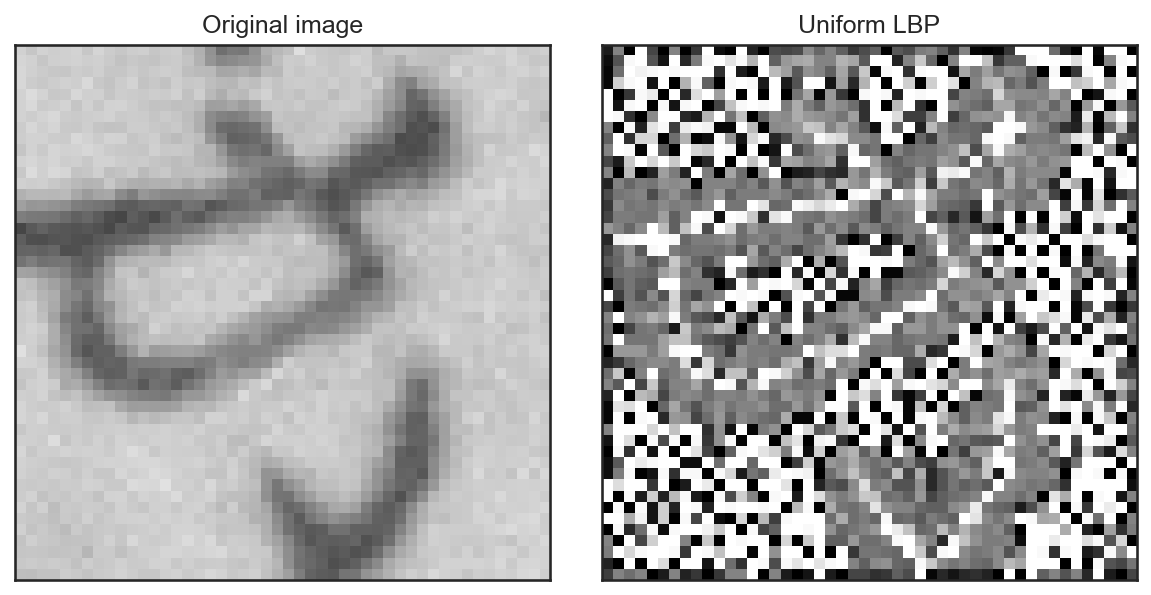

In [ ]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

ax = plt.subplot(gs[0])
ax.imshow(img, cmap="gray", vmin=0, vmax=255)
ax.set(xticks=[], yticks=[], title="Original image")

ax = plt.subplot(gs[1])
ax.imshow(lbp, cmap="gray", vmin=0, vmax=n_angles + 1)
ax.set(xticks=[], yticks=[], title="Uniform LBP")

plt.tight_layout()
plt.show()

すると、上記の通り、輝度のパターン数は36 + 2 = 38通りになることが分かる (画像の輝度が0から37の38通りになっている)。

また、画像の見た目から、文字がある部分の周りが一様に近いグレーで表現されており、回転に対してある程度の不変性を持っていそうなことも確認できる。

では、このUniform LBPを用いて、再度SVMによる文字の分類を試してみる。Uniform LBPを使う場合、画像の拡大縮小への対応力を上げるために、**中心画素からどのくらい離れたところの画素をLBPの計算に使うか**を変えつつ、LBPを取得して、それらを結合した特徴量を使う。

In [ ]:
class UniformLBPFeature(TransformerMixin):
    """
    Uniform LBPを特徴として計算するクラス
    """

    def __init__(self, image_size):
        self.image_size = image_size

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        ps = 8  # ヒストグラム計算のためのパッチサイズ
        n_angles = [8, 12, 20]
        radii = [1.0, 2.5, 4.0]
        imgs = X.reshape((-1, self.image_size[1], self.image_size[0]))
        _, h, w = imgs.shape

        features = []
        for img in tqdm(imgs, desc="Uniform LBP"):
            lbp_feat = []
            for a, r in zip(n_angles, radii):
                # LBPの計算
                lbp_img = local_binary_pattern(img, a, r, method="uniform")

                # パッチごとにヒストグラムを計算
                patches = [
                    lbp_img[y : y + ps, x : x + ps]
                    for y in range(0, h, ps)
                    for x in range(0, w, ps)
                ]
                histograms = [
                    np.histogram(patch, bins=np.arange(a + 1), density=True)[0]
                    for patch in patches
                ]
                lbp_feat.extend(histograms)

            feature = np.concatenate(lbp_feat)
            features.append(feature)

        return np.stack(features, axis=0)

In [ ]:
clf = make_pipeline(
    UniformLBPFeature(image_size=(48, 48)),
    PCA(n_components=128),
    StandardScaler(),
    SGDClassifier(loss="hinge"),
)
clf.fit(X, y)

Uniform LBP:   0%|          | 0/7360 [00:00<?, ?it/s]

Pipeline(steps=[('uniformlbpfeature',
                 <__main__.UniformLBPFeature object at 0x000001DE6E92ACE0>),
                ('pca', PCA(n_components=128)),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
# 訓練時の識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

Uniform LBP:   0%|          | 0/7360 [00:00<?, ?it/s]

Uniform LBP:   0%|          | 0/1840 [00:00<?, ?it/s]

In [ ]:
glue("ulbp_acc_train", acc_train * 100.0)
glue("ulbp_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["Uniform LBP", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["Uniform LBP", acc_test, "Test"]

88.73641304347825

71.95652173913044

**結果: Uniform LBPの利用**

- 訓練時精度: {glue:text}`ulbp_acc_train:.2f`%
- 評価時精度: {glue:text}`ulbp_acc_test:.2f`%

Uniform LBPの結果と前述のLBPの結果を比較すると、有意には精度が上昇していない。一因として、LBP特徴を用いる時点で画像をパッチに分割して特徴を取得していたために、ある程度、文字の回転に頑健な特徴となっていたということが考えられる。

Uniform LBPは回転に対して一貫した特徴を与える一方で、画像をヒストグラム化した場合には、単純なLBP画像と比べて得られる特徴が似通ってしまったという可能性も考えられる。

::::{admonition} 問
:class: question

LBPとUniform LBPについて、文字の画像の輝度を増減したり、画像を回転させたときに、パッチごとに抽出されるヒストグラム特徴がどのように変化するかを調べ、LBPとUniform LBPの精度の違いについて考察せよ。

::::

## Histogram of Oriented Gradient (HOG)

Histogram of Oriented Gradient (HOG)が広く知られるようになったのは2005年のことで、コンピュータ・ビジョンの国際会議であるCVPRで発表された論文{cite}`dalal2005histograms`がきっかけとなっている。

特にHOGは人物の全身といった特定の物体を見つける性能に優れており、一般物体認識や物体追跡等の多数の応用が生まれた。

HOGは画像を、互いに重ならない小さなパッチに分割して計算を行う。今回用いるひらがな画像は48×48の大きさなので、これを8×8のパッチに区切ってみる。

In [ ]:
ps = 8  # パッチのサイズ
img = X[0].reshape((48, 48))
h, w = img.shape
patches = [img[y : y + ps, x : x + ps] for y in range(0, h, ps) for x in range(0, w, ps)]

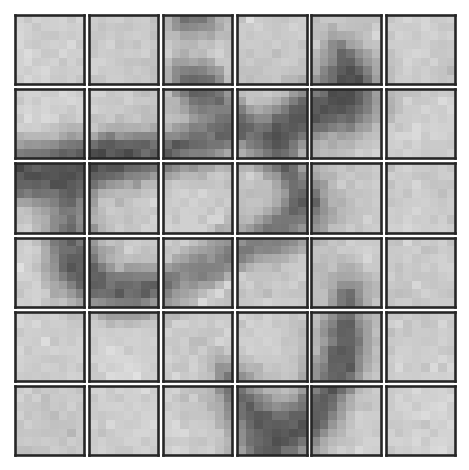

In [ ]:
fig = plt.figure(figsize=(3, 3))
gs = GridSpec(6, 6, figure=fig)

for i in range(6):
    for j in range(6):
        ax = plt.subplot(gs[i, j])
        ax.imshow(patches[i * 6 + j], cmap="gray", vmin=0, vmax=255, interpolation=None)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout(pad=0.2)
plt.show()

次に、この各画像に対して、勾配強度と勾配方向を画素ごとに計算する。以下の実装では、x方向の勾配$d_x$とy方向の勾配$d_y$をSobelフィルタを使って求め、勾配強度$g$と勾配方向$\theta$を以下のように定義する。

$$
\begin{align}
    g &= \sqrt{ d_x^2 + d_y^2 } \\
    \theta &= \text{arctan} \frac{|d_y|}{d_x}
\end{align}
$$

なお、今回は向きのない方向 (= orientation, 0°から180°)を求めるため、上記の$\theta$の式において$d_y$に絶対値がかかっていることに注意すること。

今、各パッチは8×8の大きさなので、勾配強度と勾配方向がそれぞれ64個ずつ求まる。求まった勾配方向をいくつかの方向に量子化 (今回は20°刻みで9方向)し、ヒストグラムを作成する。

この際、各画素の方向に対応するビンには**勾配強度を加算**して、ヒストグラムを計算する。

In [ ]:
n_angles = 9  # 角度の量子化数

histograms = []
for p in patches:
    dx = cv2.Sobel(p, cv2.CV_8U, 1, 0)
    dy = cv2.Sobel(p, cv2.CV_8U, 0, 1)
    dx, dy = dx.astype("float32"), dy.astype("float32")

    # 勾配強度と角度を計算
    g = np.sqrt(dx * dx + dy * dy)
    theta = 180.0 * np.arctan(np.abs(dy), dx) / np.pi
    t = (theta * n_angles / 180.0).astype("int32")

    # 勾配強度を加算してヒストグラムを作成
    h = np.zeros((n_angles), dtype="float32")
    for g_, t_ in zip(g.flatten(), t.flatten()):
        h[t_] += g_

    histograms.append(h)

histograms = np.stack(histograms, axis=0)

print(f"{len(histograms):d} histograms with {histograms.shape[1]:d} bins are obtained!")

36 histograms with 9 bins are obtained!


これにより6×6=36個のヒストグラムが求まった。ここで注意したいのは、これらのヒストグラムは勾配強度で計算されており、**場所によって、ヒストグラムのスケールが異なる**という点である。

そこで、HOGでは、この6×6=36個のパッチを3×3のブロックごとに走査し、そのブロック内で連結したヒストグラムを正規化して用いる。今、勾配方向は9つに離散化されており、ブロック内のパッチが3×3=9個なので、1ブロックが持つヒストグラムの次元は9×9=81次元である。この81次元ベクトルをノルムが1になるように正規化しておく。

最終的に、81次元のヒストグラムが複数 (今回の場合は(6-3+1)×(6-3+1)=16個)求まるので、これらを連結して、画像の特徴量として用いる。

In [ ]:
bs = 3  # ブロックサイズ
histograms = histograms.reshape((6, 6, -1))  # 6x6のパッチ

# ブロックの取り出し
blocks = np.array(
    [histograms[i : i + bs, j : j + bs] for i in range(6 - bs + 1) for j in range(6 - bs + 1)]
)
hog = blocks.reshape((-1, n_angles * bs * bs))

# ブロックごとのヒストグラムのノルムが1となるように正規化
hog = hog / np.sqrt(np.sum(hog * hog, axis=1, keepdims=True))
hog = hog.flatten()

これらの処理をまとめて特徴量抽出のクラスを作成すると次のようになる。

In [ ]:
class HOGFeature(TransformerMixin):
    def __init__(self, image_size, patch_size=8, n_angles=9, block_size=3):
        self.image_size = image_size
        self.patch_size = patch_size
        self.n_angles = n_angles
        self.block_size = block_size

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        ps = self.patch_size
        bs = self.block_size
        n_angles = self.n_angles
        imgs = X.reshape((-1, *self.image_size))

        _, h, w = imgs.shape
        ph = h // ps  # 垂直方向のパッチ数
        pw = w // ps  # 水平方向のパッチ数

        features = []
        for img in imgs:
            # パッチに分割
            patches = [
                img[y : y + ps, x : x + ps] for y in range(0, h, ps) for x in range(0, w, ps)
            ]

            # パッチごとにヒストグラムを計算
            histograms = []
            for p in patches:
                dx = cv2.Sobel(p, cv2.CV_8U, 1, 0)
                dy = cv2.Sobel(p, cv2.CV_8U, 0, 1)
                dx, dy = dx.astype("float32"), dy.astype("float32")

                g = np.sqrt(dx * dx + dy * dy)
                theta = 180.0 * np.arctan(np.abs(dy), dx) / np.pi
                t = (theta * n_angles / 180.0).astype("int32")

                hist = np.zeros((n_angles), dtype="float32")
                for g_, t_ in zip(g.flatten(), t.flatten()):
                    hist[t_] += g_

                histograms.append(hist)

            histograms = np.stack(histograms, axis=0)
            histograms = histograms.reshape((ph, pw, -1))

            # ブロックごとにヒストグラムを正規化
            blocks = np.array(
                [
                    histograms[i : i + bs, j : j + bs]
                    for i in range(ph - bs + 1)
                    for j in range(pw - bs + 1)
                ]
            )
            hog = blocks.reshape((-1, n_angles * bs * bs))
            hog = hog / (np.sqrt(np.sum(hog * hog, axis=1, keepdims=True)) + 1.0e-8)
            hog = hog.flatten()

            features.append(hog)

        return np.stack(features, axis=0)

計算されたHOGを用いて、再度SVMを用いた分類を試してみる。

In [ ]:
clf = make_pipeline(
    HOGFeature(image_size=(48, 48)),
    PCA(n_components=128),
    StandardScaler(),
    SGDClassifier(loss="hinge"),
)
clf.fit(X, y)

Pipeline(steps=[('hogfeature',
                 <__main__.HOGFeature object at 0x000001DE73279150>),
                ('pca', PCA(n_components=128)),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
# 訓練時の識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [ ]:
glue("hog_acc_train", acc_train * 100.0)
glue("hog_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["HOG", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["HOG", acc_test, "Test"]

84.90489130434783

69.56521739130434

**結果: Histogram of Oriented Gradientの利用**

- 訓練時精度: {glue:text}`hog_acc_train:.2f`%
- 評価時精度: {glue:text}`hog_acc_test:.2f`%

HOGは、画素の単純な大小を特徴化するLBPと比較して、勾配強度をヒストグラム化するという点で背景等のノイズに頑健な手法になっている。しかし、今回の文字認識の例では、LBPと比較して大きな精度向上を得ることはできないようだ。

## Bag of Visual Words

ここまでの特徴量は、画素の情報を元にして何らかのヒストグラムを得る、という方法であったが、続いては、画像に内在する画像の構造としての特徴を疎に抽出し、その特徴の集合をヒストグラム化する手法である**Bag of Visual Words** (BoVW, Bag of Featuresとも呼ばれる)について見ていく。


BoVWは、自然言語処理分野の**Bag of Words**から着想を得たもので、元のBag of Wordsは辞書に登録された各単語が文書の中に何回登場するかをヒストグラムとして表わした物である。

これに対してBag of Visual Wordsは、画像データセットから抽出された疎な特徴量の集合を単語の集まりだと見なす。ただし、画像から得られる特徴量は通常連続的であるため、特徴量をあらかじめクラスタ分割しておき、各特徴が属するクラスタを単語、クラスタの集まりを辞書と見なすことでBag of Wordsと同様の処理を可能にする。

以下では、画像に対する疎な特徴量の代表格である**Scale-Invariant Feature Transform** (SIFT)について、BoVWによる画像認識を試みる。

### Scale-Invariant Feature Transform (SIFT)

Scale-Invariant Feature Transform (SIFT)は、深層学習以前の画像認識における金字塔的な技術で、2000年前後にRoweらによって提案された{cite}`lowe1999object`, {cite}`lowe2004distinctive`。SIFTは画像の中に映り込む物体のスケールや回転に対して不変な特徴量を与えることができる。

SIFT特徴量の抽出処理は、少々複雑だが、大まかに分けて

- 特徴点の抽出
- 特徴点に対する特徴量の計算

の二つの処理に分けられる。

#### 特徴点の抽出

**特徴点の抽出**に置いては、Difference of Gaussian (DoG)というフィルタを用いて、特徴点のスケールを計算する。DoGは二つの異なる$\sigma_1$, $\sigma_2$ (ただし$\sigma_1 < \sigma_2$とする)を用いて、

$$
\text{DoG}(I) = G_{\sigma_1} \otimes I - G_{\sigma_2} \otimes I
$$

のように書ける。ただし$G_\sigma$は$\sigma$を標準偏差のパラメータとするGauss関数とする。例えば、以下のような画像になる。

In [ ]:
img = cv2.resize(X[0].reshape((48, 48)), (256, 256))
img = (img / 255.0).astype("float32")
B1 = cv2.GaussianBlur(img, None, sigmaX=2.0)
B2 = cv2.GaussianBlur(img, None, sigmaX=4.0)
DoG = B1 - B2

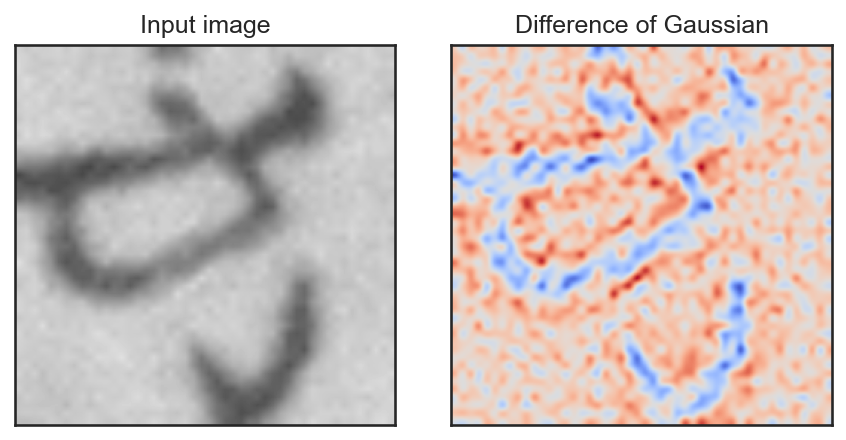

In [ ]:
fig = plt.figure(figsize=(6, 3))
gs = GridSpec(1, 2, figure=fig)
ax = plt.subplot(gs[0])
ax.imshow(img, cmap="gray", vmin=0.0, vmax=1.0)
ax.set(title="Input image", xticks=[], yticks=[])
ax = plt.subplot(gs[1])
ax.imshow(DoG, cmap="coolwarm")
ax.set(title="Difference of Gaussian", xticks=[], yticks=[])
plt.tight_layout()
plt.show()

DoGの抽出を初期のパラメータ$\sigma$とスケールパラメータ$k$を用いて、$k^n\sigma$と$k^{n+1}\sigma$の間で$n=0, 1, 2, ...$の順で計算をしていく。この計算の過程でDoGの値が極値を取っていたら、そこをキーポイントの候補点として選ぶ。

選ばれた候補点が実際に特徴点になるかどうかは、DoG値が極値を取るスケールにおいて、DoG画像$D$のその画素における勾配情報を参考にして決定する。具体的には、画像$D$から有限差分を用いて、ヘッセ行列

$$
\mathbf{H} = \begin{bmatrix}
    D_{xx} & D_{xy} \\
    D_{yx} & D_{yy} 
\end{bmatrix}
$$

を計算し、$\mathbf{H}$のトレースと行列式の比、

$$
\rho = \frac{(\text{tr} \mathbf{H})^2}{\text{det}\mathbf{H}}
$$ (eq:ratio-tr-det)

の値が一定の閾値$t$以下であれば、その候補特徴点を実際の特徴点として採用する。行列$\mathbf{H}$の固有値を$\lambda_1$, $\lambda_2$ (ただし$\lambda_1 > \lambda_2$とするとき、トレースと行列式は、それぞれ$\lambda_1 + \lambda_2$, $\lambda_1 \lambda_2$と表せるので、{eq}`eq:ratio-tr-det`は、

$$
\rho = \frac{\left( \lambda_1 + \lambda_2 \right)^2}{\lambda_1 \lambda_2} = \frac{\left( 1 + \frac{\lambda_2}{\lambda_1} \right)^2}{\frac{\lambda_2}{\lambda_1}} = \frac{(1 + r)^2}{r^2}
$$

のように書き直せる。原論文では、$r = (\lambda_2 / \lambda_1) = 10$を用いて、閾値$t$を

$$
t = \frac{(r + 1)^2}{r}
$$

のように定義している。$t$の値は$r$の変化に対して、以下のグラフのように、ほぼ線形に変化する。

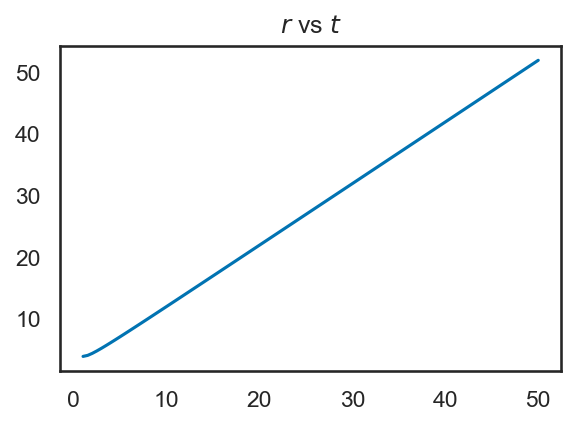

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
r = np.linspace(1.0, 50.0, 100, endpoint=True)
t = (r + 1) ** 2 / r
ax.plot(r, t)
ax.set(title="$r$ vs $t$")
plt.tight_layout()
plt.show()

以上の処理を、直感的に述べれば、前半のDoGの処理は画像中の勾配がある箇所を検出し、さらに、その**勾配がどの程度の鮮鋭度を持つのかをスケールとして定量化**しようとしている。

後半の処理、勾配の強さ (鮮鋭度は盛り上がりの角度であり、強さとは異なる)を見ており、$r = 10$とした場合に{eq}`eq:ratio-tr-det`が$t$より小さい、ということは、即ち**ヘッセ行列の2つの固有値の比が一定以下** (10:1以下)かを検証している。

なお、この$r$の値は以下のOpenCVのコードでは`edgeThreshold`という変数に対応する。もし、各画像から検出される特徴点が少なすぎるようであれば、この値を少し上げると、固有値の差が小さい(=エッジがそれほど先鋭ではない)特徴点も残されるようになる。

また、詳細は割愛するが、各特徴点には、勾配方向も同時に計算される。これは特徴点周りの画素に対して計算された勾配方向のヒストグラムの中で、いくつかの支配的な方向を特徴点に与えるものである。従って、各特徴点には2つ以上の勾配方向が割り当てられる可能性がある。

では、実際にOpenCVを用いて画像からSIFT特徴点と特徴量を計算する。以下では、特徴量の抽出結果を分かりやすくするために、48×48画素の画像を256×256画素にリサイズして特徴量を計算している。

In [ ]:
# 画像のリサイズ
img = X[0].reshape((48, 48)).copy()
img = cv2.resize(img, (256, 256))

# 特徴量抽出器の準備
sift = cv2.SIFT.create()

# 特徴点の検出
keypoints = sift.detect(img)

前述の通り、SIFT特徴点の検出では、位置、スケール、勾配方向が計算されるので、それらを`cv2.drawKeypoints`で可視化してみる。

In [ ]:
# 特徴点の描画 (画像に書き込みをするだけで表示はしない)
img_sift = cv2.drawKeypoints(
    img,
    keypoints,
    None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)

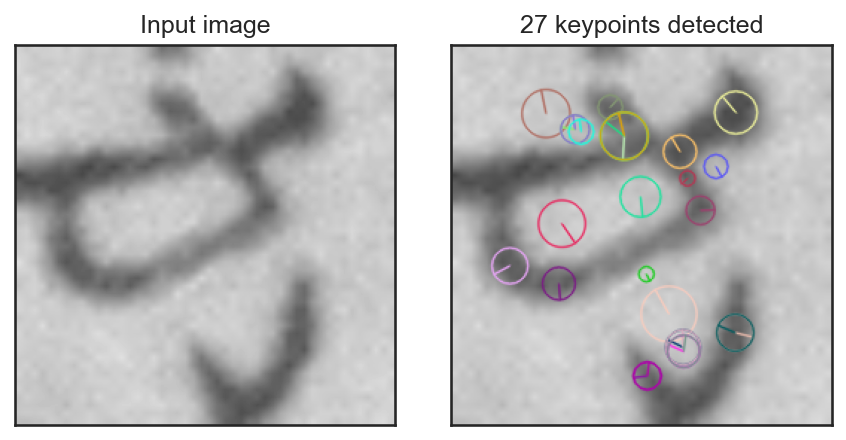

In [ ]:
fig = plt.figure(figsize=(6, 3))
gs = GridSpec(1, 2, figure=fig)
ax = plt.subplot(gs[0])
ax.imshow(img, cmap="gray", vmin=0, vmax=255)
ax.set(title="Input image", xticks=[], yticks=[])
ax = plt.subplot(gs[1])
ax.imshow(img_sift)
ax.set(
    title=f"{len(keypoints):d} keypoints detected",
    xticks=[],
    yticks=[],
)
plt.tight_layout()
plt.show()

画像中では、円の中心が特徴点の位置を、円の大きさが特徴点のスケールを、そして円の中心から弧に向かって伸びる線分が勾配方向をそれぞれ表わしている。この際、文字の輪郭線のぼけ具合と円の大きさに相関があり、なおかつ勾配方向が輪郭線とおよそ直交する方向となっていることに注目してほしい。また、特徴点の中には2つ以上の勾配方向を持つものが存在することにも注目してほしい。

#### 特徴量の計算

特徴量の計算には、特徴点の計算で得られたスケールと方向を用いる。特徴量の計算には4×4のグリッドを用いるのだが、このグリッドの大きさを特徴点のスケールに応じて拡大縮小し、また勾配方向に応じてグリッドの向きを変更する。

このグリッドは上記の特徴点の可視化に現れる特徴点のスケールを表わす円に外接するように配置される。この円の大きさは、より具体的には極大のDoG値が検出された時に用いたGauss関数の$\sigma$の大きさに対応している。

グリッドの姿勢が計算できたら、4×4=16個のグリッドのそれぞれについて、特徴点の勾配方向ヒストグラムを45°刻みの8方向について計算する。この8個のビンの値を16個分連結することで、SIFT特徴量としての128次元ベクトルが得られる。

では、先ほど求めた特徴点に対して、OpenCVを用いて特徴量(記述子=descriptorとも言う)を計算する。

In [ ]:
# 特徴量の計算
_, features = sift.compute(img, keypoints)
print(f"{features.shape[0]:d} features with {features.shape[1]:d} dimensions")

27 features with 128 dimensions


このように特徴量 (`features`)は「特徴点の数」×「特徴量の次元=128」で与えられることが確認できる。なお、特徴点の抽出と特徴量の計算は`sift.detectAndCompute`を用いることで同時に行うこともできる。

::::{admonition} 問
:class: question

SIFT特徴量がスケールや画像の回転に対して頑健であるのは何故か。その計算方法に基づき説明せよ。

::::

:::{admonition} 技術と特許
:class: note

新しい技術を開発して「特許」を取得すると、その技術の詳細を明細書として公開する代わりに、その技術に関わる権利を得ることができる。この特許は、一見、他の会社が当該の技術を使う障壁を上げており、技術の進歩にとってはマイナスな一面もある。

その一方、特許が取られていたがために、その技術を回避する目的で技術が進歩することもある。先に紹介したSIFTは当初2000年に特許が取得された(2020年に失効)が、それに変わる技術として、Speeded-Up Robust Features (SURF) {cite}`bay2006surf`などの多くの特徴量が提案された (SURFは2006年に特許が取得されており、こちらはまだ特許が切れていない)。

このような例は他の分野でも、たびたび見られるもので、CT画像から物体の表面形状を抽出するMarching Cubes法も、その特許権を回避する目的で、ほとんど同等なMarching Tetrahedra法が開発されたりした。このように、物事には表と裏とがあるのが常である。

:::

### 特徴量のクラスタリング

BoVWを計算するためには、訓練データに含まれる全ての画像について、特徴量を計算し、それをクラスタリングする必要がある。以下のコードでは、48×48という比較的小さな画像を扱うために`edgeThreshold`を調整して、検出される特徴点の数を増やしている。

In [ ]:
extractor = cv2.SIFT.create(edgeThreshold=32, contrastThreshold=0.0)

features = []
for x in tqdm(X, desc="Extract SIFT"):
    img = x.reshape((48, 48))
    keypoints, feature = extractor.detectAndCompute(img, None)
    assert len(keypoints) > 0, "No keypoints detected!"
    features.append(feature)

Extract SIFT:   0%|          | 0/7360 [00:00<?, ?it/s]

In [ ]:
all_features = np.concatenate(features, axis=0)
print(f"SIFT: {len(all_features):d} keypoints ({len(all_features) / len(X):.1f}pts per image)")

SIFT: 225613 keypoints (30.7pts per image)


特徴量が得られたら、これをk平均法 (k-means法)によってクラスタリングする。今回はOpenCVの`kmeans`関数を用いてクラスタリングを行う。

In [ ]:
from sklearn.cluster import MiniBatchKMeans

cb_size = 128  # コードブックのサイズ
cluster = MiniBatchKMeans(n_clusters=cb_size)
cluster.fit(all_features)

MiniBatchKMeans(n_clusters=128)

In [ ]:
feature = features[0]
cb_ids = cluster.predict(feature)
bovw_feat = np.bincount(cb_ids, minlength=cb_size)

In [ ]:
class BoVWFeature(TransformerMixin):
    def __init__(self, image_size, n_clusters=128):
        self.image_size = image_size
        self.extractor = cv2.SIFT.create(edgeThreshold=32, contrastThreshold=0.0)
        self.n_clusters = n_clusters
        self.cluster = MiniBatchKMeans(n_clusters=n_clusters)

    def fit(self, X, y=None):
        features = []

        # 各画像ごとにSIFT特徴を計算
        for x in tqdm(X, desc="Extract SIFT"):
            img = x.reshape(self.image_size)
            keypoints, feature = self.extractor.detectAndCompute(img, None)
            assert len(keypoints) > 0, "No keypoints detected!"
            features.append(feature)

        # k-meansクラスタリング
        features = np.concatenate(features, axis=0)
        self.cluster.fit(features)

        return self

    def transform(self, X, y=None):
        features = []
        for x in tqdm(X, desc="BoVW encoding"):
            # SIFT特徴の抽出
            img = x.reshape(self.image_size)
            keypoints, feature = self.extractor.detectAndCompute(img, None)
            assert len(keypoints) > 0, "No keypoints detected!"

            # 各特徴がどのクラスタに属するかを計算
            cb_ids = self.cluster.predict(feature)
            bovw_feat = np.bincount(cb_ids, minlength=self.n_clusters)
            bovw_feat = bovw_feat / np.sum(np.abs(bovw_feat))
            features.append(bovw_feat)

        return np.stack(features, axis=0)

In [ ]:
clf = make_pipeline(
    BoVWFeature(image_size=(48, 48), n_clusters=128),
    StandardScaler(),
    SGDClassifier(loss="hinge"),
)
clf.fit(X, y)

Extract SIFT:   0%|          | 0/7360 [00:00<?, ?it/s]

BoVW encoding:   0%|          | 0/7360 [00:00<?, ?it/s]

Pipeline(steps=[('bovwfeature',
                 <__main__.BoVWFeature object at 0x000001DE6FB6F9D0>),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

BoVW encoding:   0%|          | 0/7360 [00:00<?, ?it/s]

BoVW encoding:   0%|          | 0/1840 [00:00<?, ?it/s]

In [ ]:
glue("bovw_acc_train", acc_train * 100.0)
glue("bovw_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["BoVW", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["BoVW", acc_test, "Test"]

86.54891304347827

72.98913043478261

**結果: Bag of Visual Wordsの利用**

- 訓練時精度: {glue:text}`bovw_acc_train:.2f`%
- 評価時精度: {glue:text}`bovw_acc_test:.2f`%

### Gauss混合モデルを用いた改良

上記の例では、離散的に特徴量をクラスタ分割して、**最も近いクラスタ**に対して、各特量を割り当てることでヒストグラムを作成した。ただし、複数のクラスタの境界に特徴量が存在している可能性もあるため、その情報を捨てて、一番近いクラスタに特徴量を割り当てるのは、あまり適切とは言えない。

そこで、クラスタリングを用いる代わりに、特徴量の分布をGauss混合モデルによって近似しておき、各ガウス分布への寄与 (小数で表わされる)の和を画像の特徴ベクトルとして与えることを考える。

**Gauss混合モデル**とは、複数のGauss分布を和が1となるような正の重みによって重み付けたものであり、確率密度関数$P(\mathbf{x} | \boldsymbol\Theta)$, $\mathbf{x} \in \mathbb{R}^D$が以下の形で書ける。

$$
P(\mathbf{x} | \boldsymbol\Theta) = \sum_{k=1}^K \frac{\alpha_k}{(2 \pi)^{D / 2} \left| \boldsymbol\Sigma_k \right|^{1/2}} \exp \left( - \frac{1}{2}(\mathbf{x} - \boldsymbol{\mu}_k)^\top \boldsymbol\Sigma_k^{-1}  (\mathbf{x} - \boldsymbol{\mu}_k) \right)
$$ (eq:gaussian-mixture)

のように書ける。この式で$\boldsymbol\Theta$はパラメータの集合 $\{ \alpha_k, \boldsymbol\mu_k, \boldsymbol\Sigma_k : k = 1, \ldots, K \}$を表わし、$\alpha_k \in [0, 1)$, $\boldsymbol\mu_k \in \mathbb{R}^D$, $\boldsymbol\Sigma_k \in \mathbb{R}^{D \times D}$は、それぞれ$k$番目のGauss分布に対する混合率、分布中心、共分散行列を表わす。

ガウス混合分布を用いると、とある特徴量$\mathbf{x}$が$k$個のGauss分布のそれぞれにどの程度の寄与率$\gamma_k(\mathbf{x})$を持つかを以下のように計算できる。

$$
\gamma_k(\mathbf{x}) = \frac{\alpha_k}{(2\pi)^{D/2} \left| \boldsymbol\Sigma_k \right|^{1/2}}\frac{\exp \left( - \frac{1}{2}(\mathbf{x} - \boldsymbol{\mu}_k)^\top \boldsymbol\Sigma_k^{-1}  (\mathbf{x} - \boldsymbol{\mu}_k) \right) }{P(\mathbf{x})}
$$ (eq:membership)

これにより、特徴量$\mathbf{x}$に対する、特徴表現として、

$$
\boldsymbol\gamma = (\gamma_1(\mathbf{x}), \ldots, \gamma_K(\mathbf{x})^\top
$$

が得られる。これを画像に含まれる特徴量の集合$\mathcal{X} = \{ \mathbf{x}_i : i = 1, \ldots, N \}$に対して計算し、その平均値を画像の特徴ベクトルとする。

$$
\mathbf{f}(\mathcal{X}) = \frac{1}{N} \sum_{i=1}^N \boldsymbol\gamma(\mathbf{x}_i)
$$

ここまでの議論を踏まえて、BoVWを改善したコードが以下になる。ここではscikit-learnの`GaussianMixture`を用いてGauss混合モデルのフィッティングを行う。ただし、Gauss混合モデルのフィッティングは、かなり時間のかかる処理であるため、計算時間を短縮するために、最初に主成分分析で特徴量の次元を減らしておき、そのデータに対してGauss混合モデルをフィッティングする。

In [ ]:
from sklearn.mixture import GaussianMixture

cb_size = 32  # コードブックのサイズ
gmm = GaussianMixture(n_components=cb_size, covariance_type="diag", max_iter=10)
gmm.fit(all_features)

GaussianMixture(covariance_type='diag', max_iter=10, n_components=32)

In [ ]:
class BoVWGMMFeature(TransformerMixin):
    def __init__(self, image_size, n_clusters=32):
        self.image_size = image_size
        self.extractor = cv2.SIFT.create(edgeThreshold=32, contrastThreshold=0.0)
        self.gmm = GaussianMixture(n_components=n_clusters, covariance_type="diag", max_iter=10)

    def fit(self, X, y=None):
        features = []

        # 各画像ごとにSIFT特徴を計算
        for x in tqdm(X, desc="SIFT extraction"):
            img = x.reshape(self.image_size)
            keypoints, feature = self.extractor.detectAndCompute(img, None)
            assert len(keypoints) > 0, "No keypoints detected!"
            features.append(feature)

        # ガウス混合モデルの計算
        features = np.concatenate(features, axis=0)
        self.gmm.fit(features)

        return self

    def transform(self, X, y=None):
        features = []
        for x in tqdm(X, desc="BoVW encoding"):
            # SIFT特徴の抽出
            img = x.reshape(self.image_size)
            keypoints, feature = self.extractor.detectAndCompute(img, None)
            assert len(keypoints) > 0, "No keypoints detected!"

            # 各特徴が各クラスタに属する確率を計算
            proba = self.gmm.predict_proba(feature)
            mu = np.mean(proba, axis=0)
            std = np.std(proba, axis=0)
            feat = np.concatenate([mu, std])
            features.append(feat)

        return np.stack(features, axis=0)

In [ ]:
clf = make_pipeline(
    BoVWGMMFeature(image_size=(48, 48), n_clusters=128),
    StandardScaler(),
    SGDClassifier(loss="hinge"),
)
clf.fit(X, y)

SIFT extraction:   0%|          | 0/7360 [00:00<?, ?it/s]

BoVW encoding:   0%|          | 0/7360 [00:00<?, ?it/s]

Pipeline(steps=[('bovwgmmfeature',
                 <__main__.BoVWGMMFeature object at 0x000001DE6FAC66B0>),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

BoVW encoding:   0%|          | 0/7360 [00:00<?, ?it/s]

BoVW encoding:   0%|          | 0/1840 [00:00<?, ?it/s]

In [ ]:
glue("bovwg_acc_train", acc_train * 100.0)
glue("bovwg_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["GMM-BoVW", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["GMM-BoVW", acc_test, "Test"]

87.86684782608695

71.79347826086956

**結果: GMM-BoVW**

- 訓練時精度: {glue:text}`bovwg_acc_train:.2f`%
- 評価時精度: {glue:text}`bovwg_acc_test:.2f`%

::::{admonition} 問
:class: question

k平均法やGauss混合モデルは、教師なし学習法の一種で、そのクラスタや分布の数はユーザが必要に応じて与える必要がある。これらを自動的に決めるための指標として赤池情報基準(AIC = Akaike Information Criterion)やBayes情報基準 (=Bayes Information Criterion)がある。それぞれがどのようなものか調べよ。

::::

### Fisherベクトルの利用

BoVWの改良としてFisherベクトルを利用する手法は2007年にPerronninらによって提案された{cite}`perronnin2007fisher`。Fisherベクトルは、統計学等でも用いられるFisher情報量に基づく特徴表現である。とある確率密度分布が$\mathbf{x} \in \mathcal{X}$のパラメータ (母数)$\boldsymbol\Theta$に関する事後分布として $P(\mathbf{x} | \boldsymbol\Theta)$のように与えられる場合を考える。

#### Fisherベクトルの導出

Fisher情報量を求めるに当たり、Fisherベクトル$V(\mathbf{x}; \boldsymbol\Theta)$を

$$
V(\mathbf{x}; \boldsymbol\Theta) = \nabla_{\boldsymbol\Theta} \log P(\mathbf{x} | \boldsymbol\Theta)
$$

のように表わす。なお、確率密度関数が連続関数であるとき、このFisherベクトルの平均はゼロベクトルになる。

Fisher情報量は上記のFisherベクトルの分散として定義される。この際、Fisherベクトルの平均が$\mathbf{0}$であることを用いると次の式で与えられる。

$$
\mathbb{E}_{\mathbf{x} \sim \mathcal{X}} \left[ \nabla_{\boldsymbol\Theta} \log P(\mathbf{x} | \boldsymbol\Theta)) \right]
$$

さて、ここで、$P(\mathbf{x} | \boldsymbol\Theta)$が{eq}`eq:gaussian-mixture`のガウス混合分布で与えられる場合を考える。以後、計算を簡単にするために、共分散行列は対角成分を$\boldsymbol\sigma_k$とする対角行列であるとする。

とあるパラメータ$\theta$に関する$\ln P(\mathbf{x} | \boldsymbol\Theta)$の微分は、

$$
\frac{\partial \log P(\mathbf{x}| \boldsymbol\Theta)}{\partial \theta} = \frac{1}{P(\mathbf{x} | \boldsymbol\Theta)} \frac{\partial P}{\partial\theta}
$$

と書けることは言うまでもない。また、$P(\mathbf{x} | \boldsymbol\Theta)$の$\pi_k$, $\mu_{k,d}$, $\sigma_{k,d}$に関する偏微分はそれぞれ以下のように書ける。

$$
\begin{align}
\frac{\partial P(\mathbf{x} | \boldsymbol\Theta)}{\partial \alpha_k}
&= \frac{\exp \left( -\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu}_k)^\top \boldsymbol\Sigma_k^{-1}  (\mathbf{x} - \boldsymbol{\mu}_k) \right)}{(2\pi)^{D/2} | \boldsymbol\Sigma_k |^{1/2}} = \frac{\mathcal{N}(\mathbf{x} | \boldsymbol\mu_{k}, \boldsymbol\sigma_k)}{\alpha_k} \\
%
\frac{\partial P(\mathbf{x} | \boldsymbol\Theta)}{\partial \mu_{k,d}}
&= \alpha_k \left[ \frac{x_d - \mu_{k,d}}{\sigma_{k,d}^2} \right] \mathcal{N}(\mathbf{x} | \boldsymbol\mu_{k}, \boldsymbol\sigma_k) \\
%
\frac{\partial P(\mathbf{x} | \boldsymbol\Theta)}{\partial \sigma_{k,d}}
&= \alpha_k \left[ \frac{(x_d - \mu_{k,d})^2}{\sigma_{k,d}^3} - \frac{1}{\sigma_{k,d}} \right] \mathcal{N}(\mathbf{x} | \boldsymbol\mu_{k}, \boldsymbol\sigma_k)
\end{align}
$$

したがって、{eq}`eq:membership`の寄与率$\gamma_k$を用いると、フィッシャーベクトルの各次元は以下のように書き直せる。

$$
\begin{align}
\frac{\partial \log P(\mathbf{x}| \boldsymbol\Theta)}{\partial \alpha_k}
&= \frac{\gamma_k(\mathbf{x})}{\alpha_k} \\
%
\frac{\partial \log P(\mathbf{x}| \boldsymbol\Theta)}{\partial \mu_{k,d}}
&= \gamma_k(\mathbf{x}) \left[ \frac{x_d - \mu_{k,d}}{\sigma_{k,d}^2} \right] \\
%
\frac{\partial \log P(\mathbf{x}| \boldsymbol\Theta)}{\partial \sigma_{k,d}}
&= \gamma_k(\mathbf{x}) \left[ \frac{(x_d - \mu_{k,d})^2}{\sigma_{k,d}^3}  - \frac{1}{\sigma_{k,d}} \right]
\end{align}
$$

ここで、$\mathcal{X} = \{ \mathbf{x}_1, \ldots, \mathbf{x}_N \}$として、これらの同時分布$P(\mathcal{X} | \boldsymbol\Theta)$を考える。$\mathbf{x}_i$は互いに独立なサンプルであるので、

$$
P(\mathcal{X} | \boldsymbol\Theta) = \prod_{i=1}^N P(\mathbf{x}_i | \boldsymbol\Theta)
$$

故に、この対数尤度$L(\mathcal{X} | \boldsymbol\Theta)$は、

$$
L(\mathcal{X} | \boldsymbol\Theta) = \sum_{i=1}^N \log P(\mathbf{x}_i | \boldsymbol\Theta)
$$

となることが分かる。この尤度関数のパラメータに関する偏微分からFisherベクトルを求めると、以下のようになる。

$$
\frac{\partial L(\mathcal{X} | \boldsymbol\Theta)}{\partial \alpha_k}
= \sum_{i=1}^N \left[ \frac{\gamma_k(\mathbf{x}_i)}{\alpha_k} - \frac{\gamma_1(\mathbf{x}_i)}{\alpha_1}  \right] \quad \text{for} ~ k \geq 2  $$ (eq:deriv-alpha)

$$
\frac{\partial L(\mathcal{X} | \boldsymbol\Theta)}{\partial \mu_{k,d}}
= \sum_{i=1}^N \gamma_k(\mathbf{x}_i) \left[ \frac{x_d - \mu_{k,d}}{\sigma_{k,d}^2} \right] \\
$$ (eq:deriv-mu)

$$
\frac{\partial L(\mathcal{X} | \boldsymbol\Theta)}{\partial \sigma_{k,d}}
= \sum_{i=1}^N \gamma_k(\mathbf{x}_i) \left[ \frac{(x_d - \mu_{k,d})^2}{\sigma_{k,d}^3} - \frac{1}{\sigma_{k,d}} \right]
$$ (eq:deriv-sigma)

ただし、{eq}`eq:deriv-alpha`では、$\sum_{k} \alpha_k = 1$であることを用いて、自由度を一つ減らしてある。

ここまでの式から、Fisherベクトルの次元は$\alpha_k$に関する成分が$K - 1$次元、$\mu_{k,d}$に関する成分が$DK$次元、$\sigma_{k,d}$に関する成分が$DK$次元あるので、合計で$(2D + 1) K - 1$次元となる。

#### Fisherベクトルの意味

上記の通り、Fisherベクトルはとあるデータ集合$\mathcal{X}$を近似的に表わすGauss混合モデルについて、そのパラメータ$\boldsymbol\Theta$に関する勾配を要素に持つ。この意味を考えてみよう。

とある確率密度関数をサンプルにフィッティングする問題を考えるとき、その確率密度関数の対数尤度が最大になるようにパラメータを最適化する。従って、**Fisherベクトルの各要素は、そのパラメータの変化が、どの程度尤度に影響を与えるかを示している**、と言い換えられる。

この影響を大きさの期待値を表わしているのがFisher情報量であり、各パラメータに関するFisher情報両はFisherベクトルの各要素の二乗平均により与えられる。Fisher情報量は、推定するパラメータを正しく推定するために、どの程度十分な情報(=サンプル)が得られているかを示しており、**情報量が大きければ大きいほど、サンプルから求まるパラメータの最尤推定量が真の値に近づくことが期待される** (推定量の分散とFisher情報量の逆数の関係はCramér-Raoの不等式で与えられる)。

従って、とある画像に対して計算されるFisherベクトルは、**その画像(から得られた特徴量の集合)が、画像全体(のGauss混合分布)から見て、どのようなの意外性を持つか、と言い換えても良い**。その画像が全体のGauss混合分布にとって十分尤もらしいものであれば、尤度の勾配から定まるFisherベクトルの要素は小さな値(特に意外ではない)を取り、そうでなければ、大きな値(意外である)を取る、という訳である。

ただし、画像の分類の観点から言えば、Fisherベクトルがどのような意味を持つか、ということよりも、それ自体が、単なるクラスタへの所属や、Gauss混合モデル以上に画像を上手く表現できるような特徴を与えるということに価値がある。

実際、{eq}`eq:deriv-alpha`は画像が含む特徴量に関して、どの分布にどのくらいの割合で属するかを表わす0次統計量であるのに対し、{eq}`eq:deriv-mu`ならびに{eq}`eq:deriv-sigma`は、それぞれ1次統計量、2次統計量を表わしている。

#### Fisherベクトルを用いた画像分類

それでは、実際に全画像から取得したSIFT特徴量を用いて、各画像に対応するFisherベクトルを求めてみよう。Perronninらの元論文 {cite}`perronnin2007fisher`では、計算量を削減するために、得られたSIFT特徴量を主成分分析によって50次元減らした後、Gauss混合モデルをフィッティングしてFisherベクトルを求めている。

In [ ]:
# PCAの適用
pca = PCA(n_components=50)
all_sub_feats = pca.fit_transform(all_features)

# 次元削減結果に対してGMMを計算
sub_gmm = GaussianMixture(n_components=32, covariance_type="diag", max_iter=10)
sub_gmm.fit(all_sub_feats)

GaussianMixture(covariance_type='diag', max_iter=10, n_components=32)

In [ ]:
feature = features[0]

sub_feat = pca.transform(feature)  # (N, D)
gamma = sub_gmm.predict_proba(sub_feat)  # (N, K)
alpha = sub_gmm.weights_  # (K)
mu = sub_gmm.means_  # (K, D)
sigma = sub_gmm.covariances_  # (K, D)

g_over_a = gamma / alpha
dLda = np.sum(g_over_a[:, 1:] - g_over_a[:, 0:1], axis=0)

diff = sub_feat[:, None, :] - mu[None, :, :]  # (N, K, D)
tmp0 = diff / sigma  # (N, K, D)
dLdm = np.sum(gamma[:, :, None] * tmp0, axis=0)

tmp0 = diff**2 / (sigma[None, :, :] ** 3)
tmp1 = 1.0 / sigma[None, :, :]
dLds = np.sum(gamma[:, :, None] * (tmp0 - tmp1), axis=0)

fisher_vector = np.concatenate([dLda, dLdm.reshape((-1)), dLds.reshape((-1))])

In [ ]:
class FisherVectorFeature(TransformerMixin):
    def __init__(self, image_size, n_clusters=32):
        self.image_size = image_size
        self.extractor = cv2.SIFT.create(edgeThreshold=32, contrastThreshold=0.0)

        self.pca = PCA(n_components=50)
        self.gmm = GaussianMixture(
            n_components=n_clusters,
            covariance_type="diag",
            max_iter=10,
        )

    def fit(self, X, y=None):
        # 各画像ごとにSIFT特徴を計算
        for x in tqdm(X, desc="SIFT extraction"):
            img = x.reshape(self.image_size)
            keypoints, feature = self.extractor.detectAndCompute(img, None)
            assert len(keypoints) > 0, "No keypoints detected!"
            features.append(feature)

        # PCAを適用
        all_feats = np.concatenate(features)
        all_sub_feats = self.pca.fit_transform(all_feats)

        # GMMの計算
        self.gmm.fit(all_sub_feats)

        return self

    def transform(self, X, y=None):
        features = []
        for x in tqdm(X, desc="Fisher vector encoding"):
            # SIFT特徴の抽出
            img = x.reshape(self.image_size)
            keypoints, feature = self.extractor.detectAndCompute(img, None)
            assert len(keypoints) > 0, "No keypoints detected!"

            # 次元削減
            sub_feat = self.pca.transform(feature)

            # Fisherベクトルの計算
            gamma = self.gmm.predict_proba(sub_feat)  # (N, K)
            alpha = self.gmm.weights_  # (K)
            mu = self.gmm.means_  # (K, D)
            sigma = self.gmm.covariances_  # (K, D)

            g_over_a = gamma / alpha
            dLda = np.sum(g_over_a[:, 1:] - g_over_a[:, 0:1], axis=0)

            diff = sub_feat[:, None, :] - mu[None, :, :]  # (N, K, D)
            tmp0 = diff / sigma  # (N, K, D)
            dLdm = np.sum(gamma[:, :, None] * tmp0, axis=0)

            tmp0 = diff**2 / (sigma[None, :, :] ** 3)
            tmp1 = 1.0 / sigma[None, :, :]
            dLds = np.sum(gamma[:, :, None] * (tmp0 - tmp1), axis=0)

            fv = np.concatenate([dLda, dLdm.reshape((-1)), dLds.reshape((-1))])
            features.append(fv)

        return np.stack(features, axis=0)

In [ ]:
clf = make_pipeline(
    FisherVectorFeature(image_size=(48, 48), n_clusters=128),
    StandardScaler(),
    SGDClassifier(loss="hinge"),
)
clf.fit(X, y)

SIFT extraction:   0%|          | 0/7360 [00:00<?, ?it/s]

Fisher vector encoding:   0%|          | 0/7360 [00:00<?, ?it/s]

Pipeline(steps=[('fishervectorfeature',
                 <__main__.FisherVectorFeature object at 0x000001DE6FAC7760>),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

Fisher vector encoding:   0%|          | 0/7360 [00:00<?, ?it/s]

Fisher vector encoding:   0%|          | 0/1840 [00:00<?, ?it/s]

In [ ]:
glue("fisher_acc_train", acc_train * 100.0)
glue("fisher_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["Fisher-BoVW", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["Fisher-BoVW", acc_test, "Test"]

99.98641304347827

92.8804347826087

**結果: FisherベクトルによるBoVW**

- 訓練時精度: {glue:text}`fisher_acc_train:.2f`%
- 評価時精度: {glue:text}`fisher_acc_test:.2f`%

## 手法の比較

ここまでの手法の訓練時、ならびにテスト時のスコアを比較してみよう。今回は文字のデータを使ったために、HOGなどが画像をそのまま入力する場合と比べて若干振るわない結果となったが、BoVWなどは、画像をそのまま入力する場合と比べて大幅に高いスコアを出すことができており、特徴量抽出により、画像から分類に有益な情報を引き出せていることが分かる。

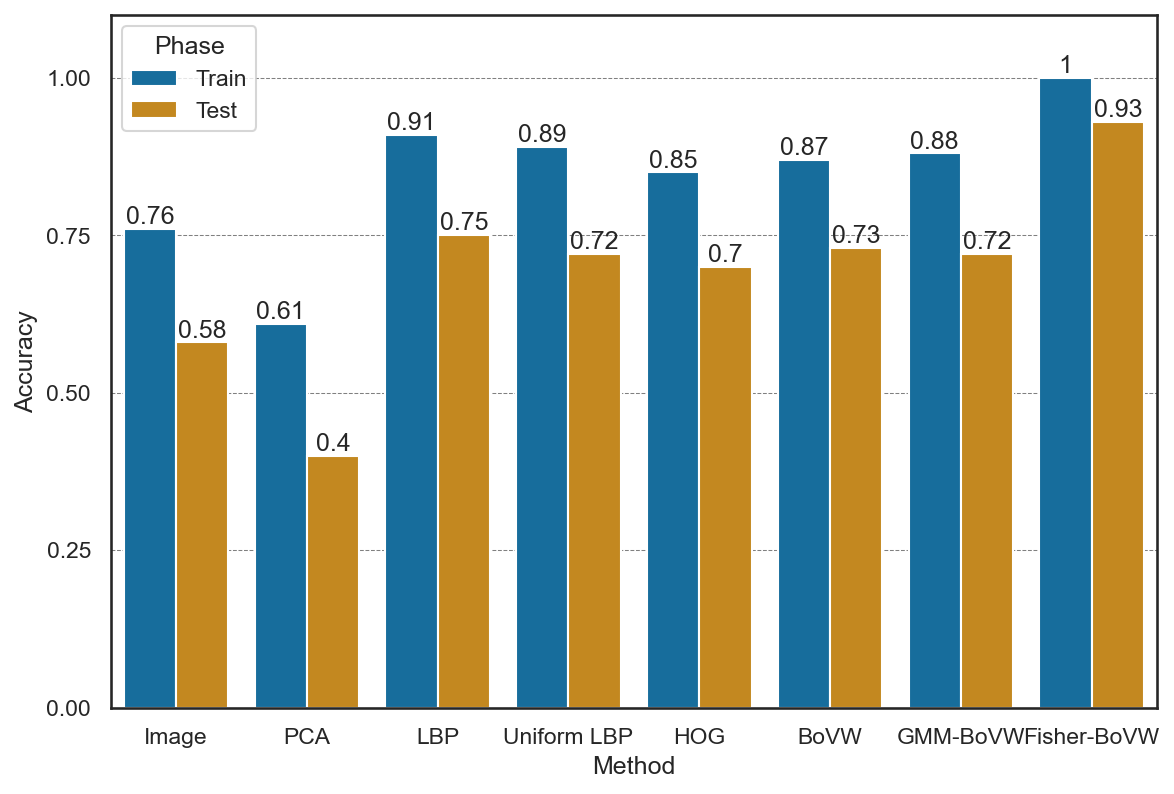

In [ ]:
plt.figure(figsize=(9, 6))

ax = sns.barplot(
    x="Method",
    y="Accuracy",
    hue="Phase",
    data=result_df.round(2),
    errwidth=0,
)

for i in ax.containers:
    ax.bar_label(i)

plt.yticks(np.linspace(0.0, 1.0, 5))
plt.ylim([0.0, 1.1])
plt.grid(axis="y", color="gray", linestyle="--", linewidth=0.5)
plt.show()

::::{admonition} 問
:class: question

BoVWの性能がSIFT以外の特徴量 (OpenCVにはORB {cite}`rublee2011orb` (=Oriented FAST and Rotated BRIEF)やKAZE {cite}`alcantarilla2012kaze` が実装されている)を使うと、どのように変化するかを調べよ。

::::

## 参考文献

```{bibliography}
:filter: docname in docnames
:style: alpha
```